### Wind Prediction using a simple MLP network

This notebook follows all the steps required for making a wind prediction using an MLP network
It is a simplification of the work performed in the thesis by Jaume Manero

-> link



In [118]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
import pandas as pd
import numpy as np
import datetime as DT
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import math
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, GaussianNoise, Input, BatchNormalization, ELU
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [187]:
path = 'e:/data_turbines/'
site = '11-5794-12'
# igual tienes que hacer una busqueda desde la original para saber la lat y la lon

### Data Analysis

We first analyze the characteristics of the data, visualizing the multivariate time series and
the different wind directions that characterize the site

In [188]:
t_s_multivariate = np.load(path+site+'.npy')
t_s_multivariate_df = pd.DataFrame(data = t_s_multivariate, columns=["wind-speed", "temp", "density", "pressure","sin", "cos", "min", "month"])
t_s_multivariate_df = t_s_multivariate_df.drop(columns=["min","month"])

a = pd.date_range(start='1-1-2007 00:00:00', end='2013-12-31 23:00:00', freq='H')
t_s_multivariate_df.insert(0,"date", a) 
t_s_multivariate_df=t_s_multivariate_df.set_index('date')
# transforma sin cos a grados

<Figure size 1440x720 with 0 Axes>

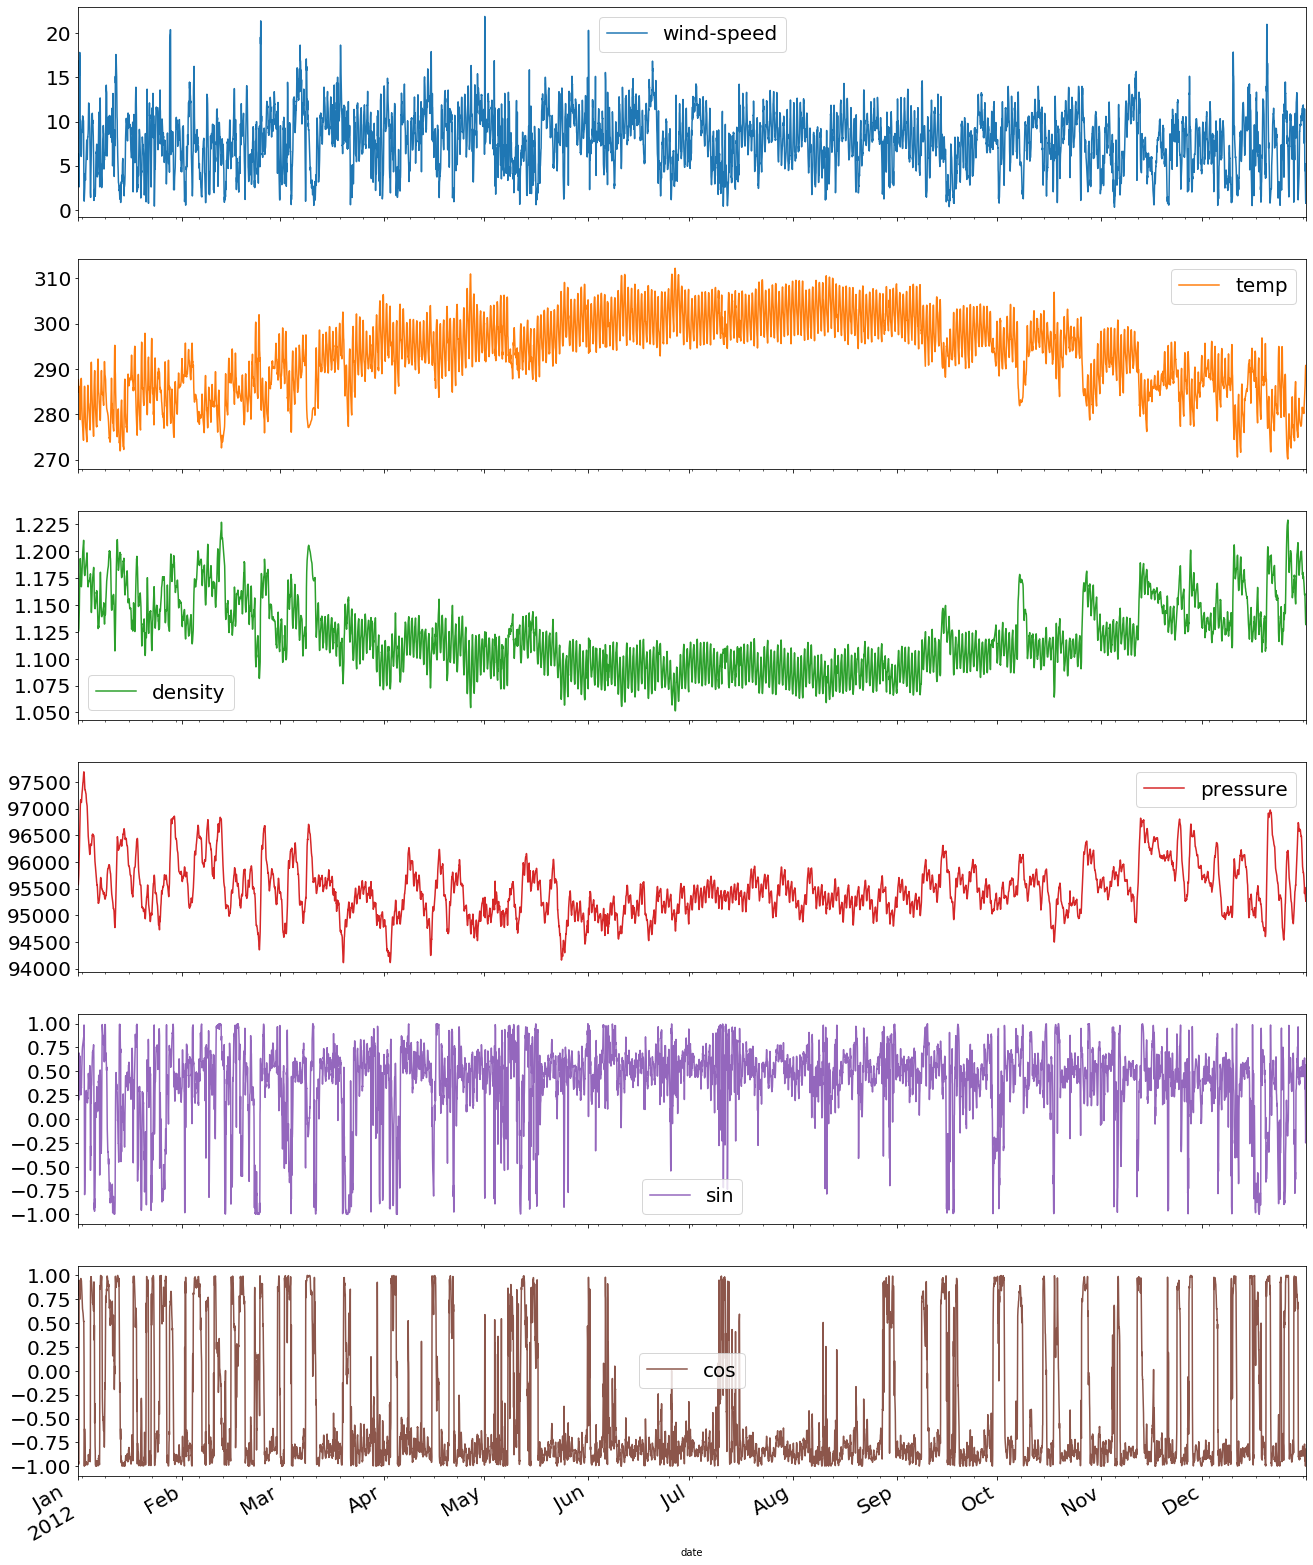

In [189]:
from_date = "2012-01-01 00:00:00"
to_date   = "2012-12-31 23:00:00"

df = t_s_multivariate_df[from_date:to_date]

plt.figure(figsize=(20,10))
plt.rc('legend', fontsize=20)
df.plot(subplots=True, legend=True, figsize=(22,30), use_index=True, fontsize=20)
plt.show()

[]

<Figure size 288x720 with 0 Axes>

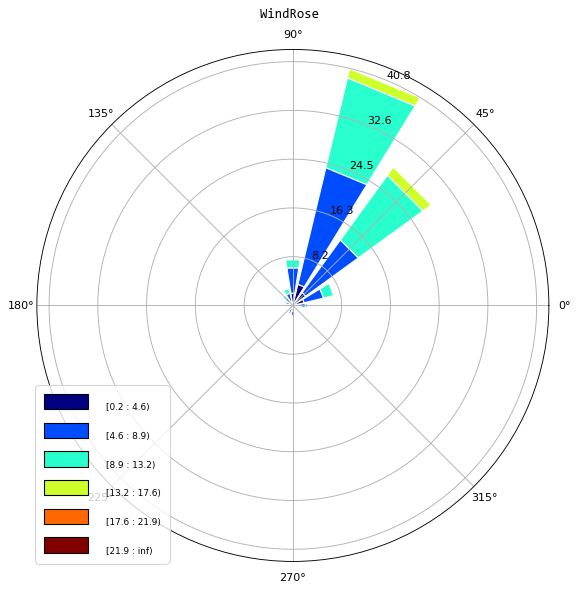

In [190]:
# Windrose to see the wind direction in a better visualization
ts_wind_speed = t_s_multivariate[:,0]
ts_sin = t_s_multivariate[:,4]
ts_cos = t_s_multivariate[:,5]
ts_degree = np.zeros(len(ts_sin))
for i in range(0,len(ts_sin)):
   phi = math.atan(ts_sin[i]/ts_cos[i])
   phi = abs(phi)*180/math.pi
   if ts_sin[i] > 0 and ts_cos[i] > 0 : # quadrant 1 (counterclockwise)
      pass
   elif ts_sin[i] < 0 and ts_cos[i] > 0: # quadrant 2 
      phi = 360 - phi
   elif ts_sin[i] < 0 and ts_cos[i] < 0: # quadrant 3 
      phi = 180 + phi
   elif ts_sin[i] < 0 and ts_cos[i] > 0: # quadrant 4 
      phi = 180 - phi
   ts_degree[i] = phi

vientospeed     = ts_wind_speed
vientodirection = ts_degree
title = 'WindRose '
plt.rc('legend', fontsize=20)
fig = plt.figure(figsize=(4,10))


ax = WindroseAxes.from_ax()
ax.bar(vientodirection, vientospeed, normed=True, opening=0.8, edgecolor='white')
ax.set_title(title, fontname="Consolas")
ax.set_legend()
ax.plot()


### Prediction

Prediction is made in 4 major steps

(1) Data Matrix Preparation: The data for the Network training is prepared. Basically consists in slicing the data in examples as input    
(2) MLP Network design: We define the Artificial Neural Network to be used  
(3) MLP Training  
(4) MLP Results verification

### Data Matrix Preparation

In [191]:
# Transform data input into examples data to be used by network
# input (61368,8) -> output (61338,30,8)
# trainsize (5y) + testsize (2y) = 61368 steps
# create train, test, val 
lag = 12
ahead = 12

trainsize =  43834
testsize = 17534
datasize = trainsize

sc=StandardScaler()
tmpdata = sc.fit_transform(t_s_multivariate)
Scaler = sc.fit(t_s_multivariate[:, 0].reshape(-1, 1))  # saves the scaler for the first variable for descaling
t_s_multivariate = tmpdata


def lag_matrix(wind_train, lag=lag, ahead=ahead):
    wind_train = data[:trainsize, :]
    lvect = []
    for i in range(lag + ahead):
       lvect.append(data[i: -lag - ahead + i, :])
    return(np.stack(lvect, axis=1))

# data = train -> test -> val

trainsize =  43834
testsize = 17534   # testsize = test + val

data = t_s_multivariate[:trainsize, :]

train = lag_matrix(data, lag, ahead)

train_x = train[:, :lag]
train_x = np.swapaxes(train_x, 1, 2)
train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1] * train_x.shape[2]))

data  = t_s_multivariate[trainsize:trainsize + testsize, :]

test  = lag_matrix(data, lag, ahead)
half_test = int(test.shape[0] / 2)

test_x = test[:half_test, :lag]
val_x = test[half_test:, :lag]

train_y = train[:, -12:, 0]
test_y   = test[:half_test, -12:, 0]
val_y  = test[half_test:, -12:, 0]


test_x = np.swapaxes(test_x, 1, 2)
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1] * test_x.shape[2]))
val_x = np.swapaxes(val_x, 1, 2)
val_x = np.reshape(val_x, (val_x.shape[0], val_x.shape[1] * val_x.shape[2]))


print("=========== SHAPE INPUT-OUTPUT MATRIXES =====================")
print("shape x_training :", train_x.shape, " y_training: : ", train_y.shape)
print("shape x_test     : ", test_x.shape, " y_test      : ", test_y.shape)
print("shape x_val      : ", val_x.shape,  " y_val       : ", val_y.shape)
print("=============================================================")

input_dimensions = train_x.shape[1:]
print(input_dimensions)

=========== SHAPE INPUT-OUTPUT MATRIXES =====================
shape x_training : (43810, 96)  y_training: :  (43810, 12)
shape x_test     :  (8755, 96)  y_test      :  (8755, 12)
shape x_val      :  (8755, 96)  y_val       :  (8755, 12)
(96,)


In [192]:
# revisar las matrices creo que esta bien

### Multi-layer perceptron model definition

Here we define an MLP network this is the model basis for the prediction

In [193]:
data_input = Input(shape=input_dimensions)
layer = Dense(1024)(data_input)
layer = ELU(alpha=0.3)(layer)
layer = Dropout(rate=0.3)(layer)
layer = Dense(512, activation= 'elu')(layer)
layer = Dropout(rate=0.3)(layer)
output = Dense(12, activation='linear')(layer)

MLP = Model(inputs=data_input, outputs=output, name='MLP')
MLP.summary()
MLP.compile(loss='mean_squared_error',optimizer="adamax", )

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 96)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 1024)              99328     
_________________________________________________________________
elu_9 (ELU)                  (None, 1024)              0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 12)                6156    

In [194]:
batch_size = 1024
nepochs = 200
early = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

MLP.fit(train_x, train_y, batch_size=batch_size, epochs=nepochs, validation_data=(test_x, test_y), verbose=True, callbacks=[early])
#, callbacks=cbacks

Train on 43810 samples, validate on 8755 samples
Epoch 1/200
43810/43810 [==============================] - 5s 110us/step - loss: 0.7438 - val_loss: 0.4424
Epoch 2/200
43810/43810 [==============================] - 4s 86us/step - loss: 0.5252 - val_loss: 0.4211
Epoch 3/200
43810/43810 [==============================] - 4s 86us/step - loss: 0.4988 - val_loss: 0.4127
Epoch 4/200
43810/43810 [==============================] - 4s 87us/step - loss: 0.4847 - val_loss: 0.4077
Epoch 5/200
43810/43810 [==============================] - 4s 87us/step - loss: 0.4763 - val_loss: 0.4061
Epoch 6/200
43810/43810 [==============================] - 4s 87us/step - loss: 0.4691 - val_loss: 0.4046
Epoch 7/200
43810/43810 [==============================] - 4s 87us/step - loss: 0.4657 - val_loss: 0.4075
Epoch 8/200
43810/43810 [==============================] - 4s 87us/step - loss: 0.4604 - val_loss: 0.4029
Epoch 9/200
43810/43810 [==============================] - 4s 86us/step - loss: 0.4555 - val_loss: 0.3

In [195]:
val_yp = MLP.predict(val_x, batch_size=batch_size, verbose=0)
test_yp = MLP.predict(test_x, batch_size=batch_size, verbose=0)

In [196]:
#evaluate result

In [202]:
lresults = []
val_y_R2 = []
test_y_R2 = []
acum_val, acum_test = 0,0
for i in range (1,12+1):
   val_y_R2.append(r2_score(Scaler.inverse_transform(val_y[:, i - 1]), Scaler.inverse_transform(val_yp[:, i - 1])))
   test_y_R2.append(r2_score(Scaler.inverse_transform(test_y[:, i - 1]), Scaler.inverse_transform(test_yp[:, i - 1])))
   
print ("Results === Test == Validation ")
print('=============================')
for i in range (0,12):
   print('step', "{:<4d}".format(i+1), '- ', "{:.3f}".format(val_y_R2[i]), "   {:.3f}".format(test_y_R2[i]))          
   acum_val = acum_val + val_y_R2[i]
   acum_test = acum_test + test_y_R2[i]
print('=============================')
print('Summary', '  - ', "{:.3f}".format(acum_val), "   {:.3f}".format(acum_test))

Results === Test == Validation 
step 1    -  0.901    0.907
step 2    -  0.794    0.816
step 3    -  0.712    0.755
step 4    -  0.651    0.705
step 5    -  0.598    0.660
step 6    -  0.550    0.619
step 7    -  0.508    0.583
step 8    -  0.475    0.551
step 9    -  0.446    0.526
step 10   -  0.424    0.506
step 11   -  0.411    0.490
step 12   -  0.398    0.474
Summary   -  6.867    7.591
